# Udacity Data Science Nano Degree Capstone Project 
## Sparkify - Predicting Customer Churn

This notebook details my work on predicting customer churn for <b> Sparkify</b>, a fictitious music streaming service that offers both free and paid levels. <br>
I undertake this project as part of Udacity's Data Science NanoDegree.<p>
    
The goal of the project is to build a model/models to help Sparkify with their goal of customer retention. In order to accomplish this task, we must be able to determine which users are in danger of cancelling the service and (optionally) which paid users are in danger of downgrading to the free version. <p>
Customers in danger of churning (according to the model's predictions) could then be targeted for retention strategy.
    
Sparkify has provided an extremely rich 12GB dataset that details user actions at the level of each individual action. <br>
In this notebook we will examine a subset (128MB) of this dataset using <b> PySpark </b> in order to familiarize ourselves with the data and develop our scripts. <br>
Then, we will be prepared to run these scripts on a fully fledged Spark Cluster against the entire dataset. <p>

In [1]:
# get pyarrow - for pandas udf
!pip install pyarrow==0.14.1

    100% |████████████████████████████████| 58.2MB 602kB/s eta 0:00:01  8% |██▋                             | 4.7MB 32.7MB/s eta 0:00:02    13% |████▍                           | 7.9MB 24.8MB/s eta 0:00:03    24% |███████▉                        | 14.3MB 32.4MB/s eta 0:00:02    40% |█████████████                   | 23.5MB 29.5MB/s eta 0:00:02    45% |██████████████▌                 | 26.4MB 29.5MB/s eta 0:00:02    52% |█████████████████               | 30.7MB 31.5MB/s eta 0:00:01    57% |██████████████████▌             | 33.6MB 31.0MB/s eta 0:00:01    60% |███████████████████▎            | 35.0MB 30.4MB/s eta 0:00:01    62% |████████████████████            | 36.5MB 29.2MB/s eta 0:00:01    83% |██████████████████████████▊     | 48.6MB 28.0MB/s eta 0:00:01    90% |████████████████████████████▉   | 52.4MB 26.1MB/s eta 0:00:01    91% |█████████████████████████████▍  | 53.5MB 19.6MB/s eta 0:00:01    95% |██████████████████████████████▊ | 55.8MB 22.4MB/s eta 0:00:01    99% |████████████████

In [2]:
# get the ua-parser to parse useragents 
!pip install pyyaml ua-parser user-agents
from user_agents import parse

  Running setup.py bdist_wheel for user-agents ... done
  Stored in directory: /root/.cache/pip/wheels/99/f3/df/12f8953cef0e59c251c6e9cf7816d202e8e778a3a928a645a6
Successfully built user-agents


In [3]:
import numpy as np
import datetime
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
np.__version__

'1.18.3'

In [4]:
# import libraries
from pyspark.sql import SparkSession

from pyspark.sql.types import StringType, IntegerType, StructType, StructField, DoubleType, BooleanType
from pyspark.sql import Window 

import pyspark.sql.functions as F
from pyspark.sql.functions import udf, desc, asc, concat, col, lit, when
from pyspark.sql.functions import pandas_udf, PandasUDFType

from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator
from pyspark.ml.feature import VectorIndexer, VectorAssembler, Imputer, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, GBTClassifier


In [5]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Customer Churn Prediction") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [6]:
def load_json_data(json_path):
    """Load spark data frame JSON path.
        Args:
            json_path (string): path to json file
        Returns:
            df (PySpark DataFrame): data read from json
    """
    return spark.read.json(json_path)

In [7]:
json_path = "mini_sparkify_event_data.json"
user_log = load_json_data(json_path)

We will be examining several aspects of the data, including schema, dimension, and missing values

In [8]:
# schema of the df
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [9]:
# look at the 1st row
user_log.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [10]:
# check the shape of the dataframe
def check_shape(df):
    """Print the dimensions of a PySpark DataFrame"""
    print((df.count(), len(df.columns)))

check_shape(user_log)

(286500, 18)


We have 286k rows and 18 columns in our dataframe.
Now, let's check how many values are empty in each column, so that we can clean the data if necessary.

In [11]:
def check_nulls(df):
    """Count null values in PySpark dataframe.
        Args:
            df (PySpark DataFrame): data
        Returns:
            nulls_dict (dict): dictionary of column:num_nulls
    """
    check_nulls = [c[0] for c in df.dtypes if c[1] != 'boolean']
    pd_nulls = df\
        .select([F.count(when(col(c).isNull(), c)).alias(c) for c in check_nulls])\
        .toPandas()\
        .T
    pd_nulls.columns=["num"]
    nulls_dict = pd_nulls.num.to_dict()
    
    return nulls_dict

In [12]:
nulls = check_nulls(user_log)

In [13]:
nulls

{'artist': 58392,
 'auth': 0,
 'firstName': 8346,
 'gender': 8346,
 'itemInSession': 0,
 'lastName': 8346,
 'length': 58392,
 'level': 0,
 'location': 8346,
 'method': 0,
 'page': 0,
 'registration': 8346,
 'sessionId': 0,
 'song': 58392,
 'status': 0,
 'ts': 0,
 'userAgent': 8346,
 'userId': 0}

We can see that we have around 8k rows where there is no userId. As we are attempting to predict user-level churn, we will drop rows where userId is blank. It can be surmised that wherever userId is empty, additional user-level data such as gender and Name are also empty.<br>
We can also see that we have around 58k rows where song-level data is not populated. We will briefly examine a few of these rows to determine if they pose a problem.

In [14]:
# 3 rows where song is null
user_log.filter("song IS NULL OR artist IS NULL").take(3)

[Row(artist=None, auth='Logged In', firstName='Colin', gender='M', itemInSession=54, lastName='Freeman', length=None, level='paid', location='Bakersfield, CA', method='PUT', page='Add to Playlist', registration=1538173362000, sessionId=29, song=None, status=200, ts=1538352905000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist=None, auth='Logged In', firstName='Micah', gender='M', itemInSession=84, lastName='Long', length=None, level='free', location='Boston-Cambridge-Newton, MA-NH', method='GET', page='Roll Advert', registration=1538331630000, sessionId=8, song=None, status=200, ts=1538353150000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist=None, auth='Logged In', firstName='Micah', gender='M', itemInSession=86, lastName='Long', length=None, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='T

In [15]:
user_log.filter("song IS NOT NULL").take(3)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

From the above rows, we can see that song-level data, such as Artist, Length, and Song, are populated when the page is "NextSong". Other pages, such as "Home" or "Add to Playlist" do not populate song-level data. <br>
This makes sense, as these pages represent actions where the user is not actively listening to music. Therefore we should not expect rows with missing song-level data to pose an issue for us in this analysis.

We'll now clean the data by dropping rows where userId is blank.

In [16]:
df = user_log.filter("userId != ''")

Check to make sure we got rid of all the empties we expected to.

In [17]:
check_nulls(df)

{'artist': 50046,
 'auth': 0,
 'firstName': 0,
 'gender': 0,
 'itemInSession': 0,
 'lastName': 0,
 'length': 50046,
 'level': 0,
 'location': 0,
 'method': 0,
 'page': 0,
 'registration': 0,
 'sessionId': 0,
 'song': 50046,
 'status': 0,
 'ts': 0,
 'userAgent': 0,
 'userId': 0}

What are the unique actions that a user can take on Sparkify? How common is each action?

In [18]:
df\
    .select('page', 'ts')\
    .groupby('page')\
    .count()\
    .orderBy(F.desc('count'))\
    .show()

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Home| 10082|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|            Settings|  1514|
|                Help|  1454|
|             Upgrade|   499|
|               About|   495|
|       Save Settings|   310|
|               Error|   252|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+



We should also take a look at some basic session information to determine if there are any outliers that need to be removed or if there are any anamolies in the dataset. Count of sessions over time may be a useful feature so it's a good idea to check it out.

In [19]:
session_examine = df\
    .groupby("sessionId")\
    .agg(
        F.max("itemInSession").alias("itemsInSession"), 
        F.min("ts").alias("firstHit"),
        F.max("ts").alias("lastHit")
    )\
    .withColumn("sessionLengthMinutes", (col("lastHit") - col("firstHit")) / 1000 / 60)\
    .drop("firstHit", "lastHit")\
    .toPandas()

In [20]:
session_examine.head()

,sessionId,itemsInSession,sessionLengthMinutes
0,29,91,157.633333
1,26,82,221.683333
2,474,9,26.733333
3,964,7,16.333333
4,1697,218,791.733333


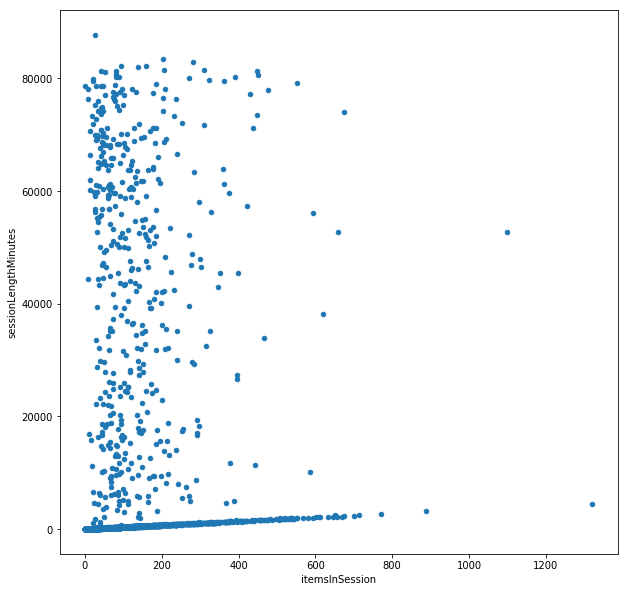

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
_ = session_examine.plot(kind='scatter', x="itemsInSession", y="sessionLengthMinutes", ax=ax)

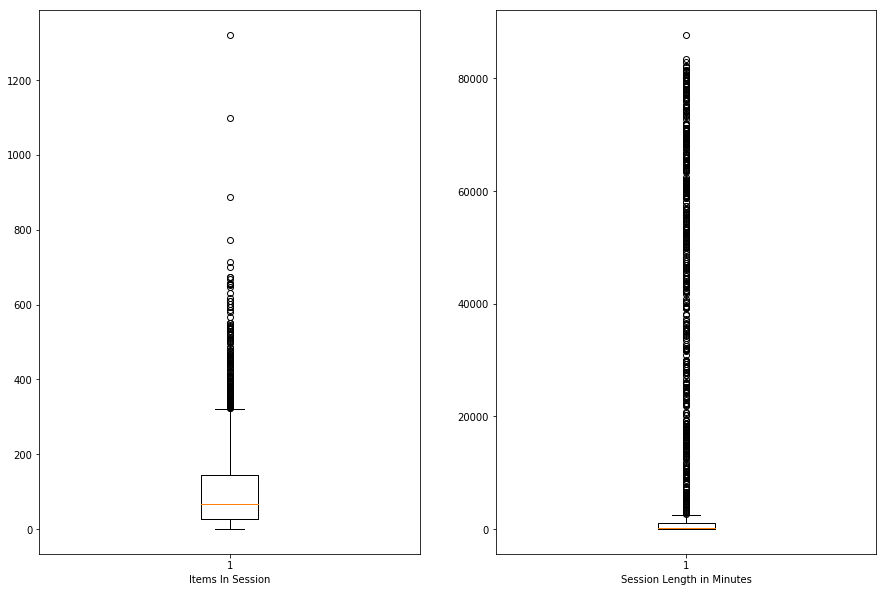

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
_ = ax[0].boxplot(session_examine.itemsInSession)
_ = ax[0].set_xlabel('Items In Session')
_ = ax[1].boxplot(session_examine.sessionLengthMinutes)
_ = ax[1].set_xlabel('Session Length in Minutes')

In [23]:
session_examine.describe()

,sessionId,itemsInSession,sessionLengthMinutes
count,2312.000000,2312.000000,2312.000000
mean,1183.699394,108.475779,8964.949012
std,690.855976,123.762525,20525.300030
min,1.000000,0.000000,0.000000
25%,584.750000,27.000000,91.812500
50%,1177.500000,66.000000,279.875000
75%,1776.250000,145.000000,1120.079167
max,2474.000000,1321.000000,87739.100000


It would appear that we have some sessions that are abnormally long. 88,000 minutes is 61 days! <br>
Quite suspicious. <br>
However, we don't want to throw any data out if we don't have to - maybe we can reparition user activity into new sessions.

We will look for rows where the next hit in the session is greater than 2 hrs in the future.

In [24]:
df\
    .withColumn("nextHit", F.lead("ts").over(Window.partitionBy("sessionId").orderBy("ts")))\
    .withColumn("nextHitDiffMin", (col("nextHit") - col("ts")) / 1000 / 60)\
    .withColumn("timestamp", F.from_unixtime(col("ts") / 1000))\
    .withColumn("nextHitTimestamp", F.from_unixtime(col("nextHit") / 1000))\
    .filter("nextHitDiffMin > 120")\
    .select("userId", "sessionId", "ts", "nextHit", "nextHitDiffMin", "timeStamp", "nextHitTimeStamp")\
    .orderBy(*["sessionId", "ts"])\
    .take(5)

[Row(userId='300001', sessionId=1, ts=1538428795000, nextHit=1538974195000, nextHitDiffMin=9090.0, timeStamp='2018-10-01 21:19:55', nextHitTimeStamp='2018-10-08 04:49:55'),
 Row(userId='100003', sessionId=3, ts=1539100613000, nextHit=1539356097000, nextHitDiffMin=4258.066666666667, timeStamp='2018-10-09 15:56:53', nextHitTimeStamp='2018-10-12 14:54:57'),
 Row(userId='100006', sessionId=6, ts=1538753070000, nextHit=1539351763000, nextHitDiffMin=9978.216666666667, timeStamp='2018-10-05 15:24:30', nextHitTimeStamp='2018-10-12 13:42:43'),
 Row(userId='100009', sessionId=9, ts=1538379600000, nextHit=1538565146000, nextHitDiffMin=3092.4333333333334, timeStamp='2018-10-01 07:40:00', nextHitTimeStamp='2018-10-03 11:12:26'),
 Row(userId='300009', sessionId=9, ts=1538581429000, nextHit=1538965220000, nextHitDiffMin=6396.516666666666, timeStamp='2018-10-03 15:43:49', nextHitTimeStamp='2018-10-08 02:20:20')]

We can see from the above rows that we have sessions with abnormally long times between "hits". In order to preserve our dataset and not throw out data unnecessarily, we'll define a new sessionId that breaks up our abnormally long sessions. <br>
Let's also check to make sure that sessions are unique by userId.

In [25]:
df\
    .select('sessionId', 'userId')\
    .dropDuplicates()\
    .groupby('sessionId')\
    .agg(F.count('userId').alias('userCnt'))\
    .filter('userCnt > 1')\
    .count()

466

They are not! Our new sessionId will solve for that. <br>
We'll create an entirely new sessionId by breaking up user activity into phases. <br>
A phase will end when the next hit for the user is null (end of user activity) or the next hit for the user is over 30 minutes away. <br>
We'll also make sure to reset our `itemInSession` count for these new sessions. <br>
Additionally, we'll set a flag to indicate a song was skipped if the next hit for the user comes 30 seconds before the expected end of the song.

In [26]:
# calculate difference in minutes to next hit for userId.
# if next hit is > 30 mins away or null, set 1 for sessionEnd flag
# if page is "logout", set 1 for sessionEndFlag

df = df \
    .withColumn("activityDay", F.to_date(F.from_unixtime(col('ts') / 1000)))\
    .withColumn("firstActivityDay", F.min(col("activityDay")).over(Window.partitionBy(col('userId'))))\
    .withColumn("daysSinceFirst", F.datediff(col("activityDay"), col("firstActivityDay")))\
    .withColumn('nextHit', 
                F.lead('ts', count=1, default=0)\
                    .over(Window\
                        .partitionBy('userId')\
                        .orderBy('ts')
                    )
    )\
    .withColumn('nextHitDiffMin',
                ((col('nextHit') - col('ts')) / 60 / 1000)
    )\
    .withColumn('nextHitDiff',
                (col('nextHit') - col('ts'))
    )\
    .withColumn('sessionEnd',
               F.when((col('nextHit') == 0) |\
                      (col('nextHitDiffMin') > 30) | \
                      (col('page') == 'Logout'), 1)\
                .otherwise(0)\
    )\
    .withColumn('sessionPhase',
               F.sum('sessionEnd')\
                    .over(Window\
                         .partitionBy('userId')\
                         .orderBy(F.desc('ts'))
                    )
    )\
    .withColumn('newSessionId',
               F.dense_rank().over(Window.orderBy(*['userId', 'sessionPhase']))
    )\
    .withColumn('cancelFlag', F.when((col('page') == 'Cancellation Confirmation'), 1).otherwise(0))\
    .withColumn('cancelPhase',
               F.sum('cancelFlag')\
                    .over(Window\
                         .partitionBy('userId')\
                         .orderBy(F.desc('ts'))
                    )
    )\
    .withColumn('userCancelPhase',
               F.dense_rank().over(Window.orderBy(*['userId', 'cancelPhase']))
    )\
    .withColumn('newItemInSession',
                F.row_number().over(Window\
                                    .partitionBy('newSessionId')\
                                    .orderBy('ts'))
    )\
    .drop('itemInSession', 'sessionId')\
    .withColumn("songSkip", \
                F.when((col('page') == 'NextSong') &\
                       ((col('length') - (col('nextHitDiff') / 1000)) >= 30) &\
                       (col('nextHit') != 0), 1).otherwise(0))

In [27]:
df.take(1)

[Row(artist=None, auth='Logged In', firstName='Brycen', gender='M', lastName='Bradley', length=None, level='paid', location='Laurel, MS', method='GET', page='Home', registration=1538159495000, song=None, status=200, ts=1542631690000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='10', activityDay=datetime.date(2018, 11, 19), firstActivityDay=datetime.date(2018, 10, 8), daysSinceFirst=42, nextHit=1542631753000, nextHitDiffMin=1.05, nextHitDiff=63000, sessionEnd=0, sessionPhase=1, newSessionId=1, cancelFlag=0, cancelPhase=0, userCancelPhase=1, newItemInSession=1, songSkip=0)]

Make sure sessions are unique to users

In [28]:
df\
    .select('newSessionid', 'userId')\
    .dropDuplicates()\
    .groupby('newSessionId')\
    .agg(F.count('userId').alias('userCnt'))\
    .filter('userCnt > 1')\
    .count()

0

Examine our newly partitioned sessions

In [29]:
new_session_examine = df\
    .groupby("newSessionId", "userId")\
    .agg(
        F.max("newItemInSession").alias("itemsInSession"), 
        F.min("ts").alias("firstHit"),
        F.max("ts").alias("lastHit")
    )\
    .withColumn("sessionLengthMinutes", (col("lastHit") - col("firstHit")) / 1000 / 60)\
    .drop("firstHit", "lastHit")\
    .toPandas()

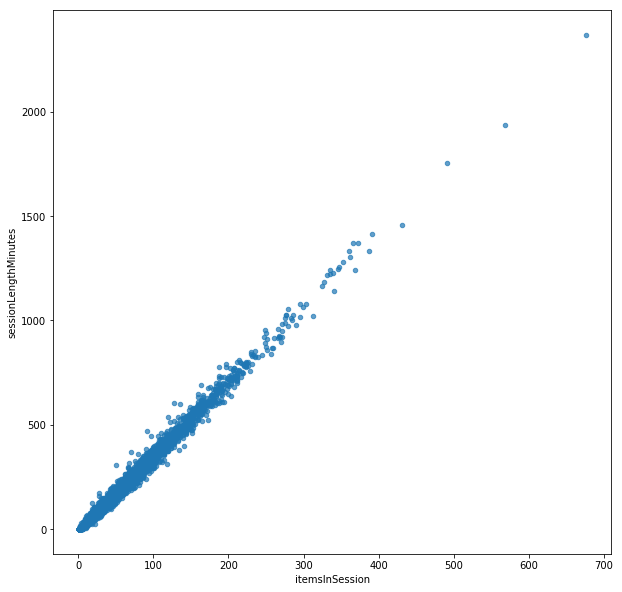

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
_ = new_session_examine.plot(kind='scatter', x="itemsInSession", y="sessionLengthMinutes", ax=ax, alpha=0.7)

We'll check for outliers and remove them.

In [31]:
z_scores = np.abs(stats.zscore(new_session_examine.sessionLengthMinutes))
valid_mask = (z_scores < 4) 
valid_sessions = new_session_examine.loc[valid_mask]
valid_sessions.head()
#new_session_examine.sessionLengthMinutes[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

,newSessionId,userId,itemsInSession,sessionLengthMinutes
0,1,10,3,1.633333
1,2,10,67,232.400000
2,3,10,25,96.916667
3,4,10,41,174.083333
4,5,10,20,62.683333


In [32]:
new_session_examine.loc[~valid_mask].head()

,newSessionId,userId,itemsInSession,sessionLengthMinutes
44,45,100,313,1019.583333
157,158,100008,491,1756.016667
410,411,101,366,1372.600000
723,724,115,277,1026.383333
783,784,118,251,909.833333


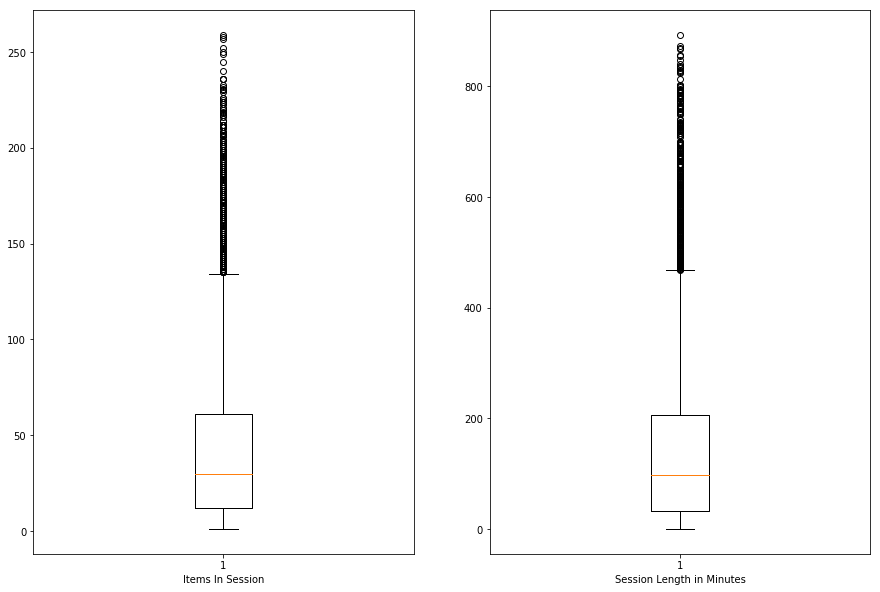

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
_ = ax[0].boxplot(valid_sessions.itemsInSession)
_ = ax[0].set_xlabel('Items In Session')
_ = ax[1].boxplot(valid_sessions.sessionLengthMinutes)
_ = ax[1].set_xlabel('Session Length in Minutes')

8.148333333333333

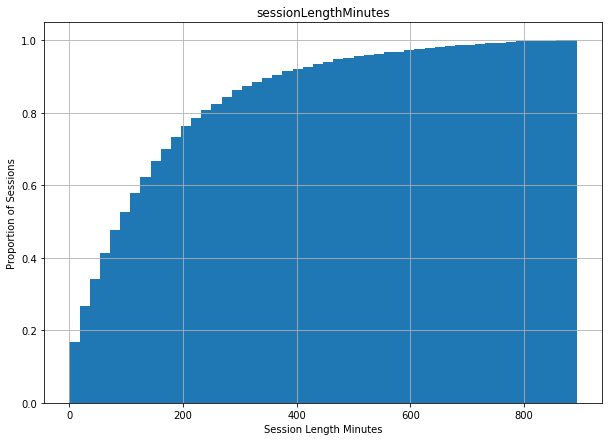

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

_ = valid_sessions.hist('sessionLengthMinutes', bins=50, cumulative=True, density=True, ax=ax)
ax.set_ylabel('Proportion of Sessions')
ax.set_xlabel('Session Length Minutes')

np.percentile(valid_sessions.sessionLengthMinutes, 95) / 60

Roughly 95% of sessions are less than 8 hours

In [35]:
valid_sessions.describe()

,newSessionId,itemsInSession,sessionLengthMinutes
count,5941.000000,5941.000000,5941.000000
mean,2995.855917,44.102003,148.719907
std,1729.985411,44.489382,159.374273
min,1.000000,1.000000,0.000000
25%,1499.000000,12.000000,32.100000
50%,2995.000000,30.000000,97.700000
75%,4493.000000,61.000000,206.866667
max,5991.000000,259.000000,893.033333


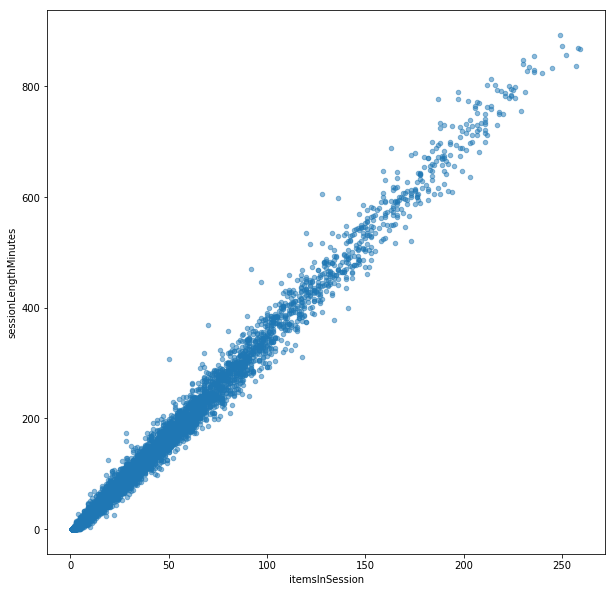

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
_ = valid_sessions.plot(kind='scatter', x="itemsInSession", y="sessionLengthMinutes", ax=ax, alpha=0.5)

Check the avg session length for users.

In [37]:
user_session_examine = valid_sessions\
    .groupby("userId")\
    .sessionLengthMinutes\
    .mean()\
    .reset_index()

In [38]:
user_session_examine.head()

,userId,sessionLengthMinutes
0,10,161.342157
1,100,156.213802
2,100001,63.261111
3,100002,160.910000
4,100003,39.350000


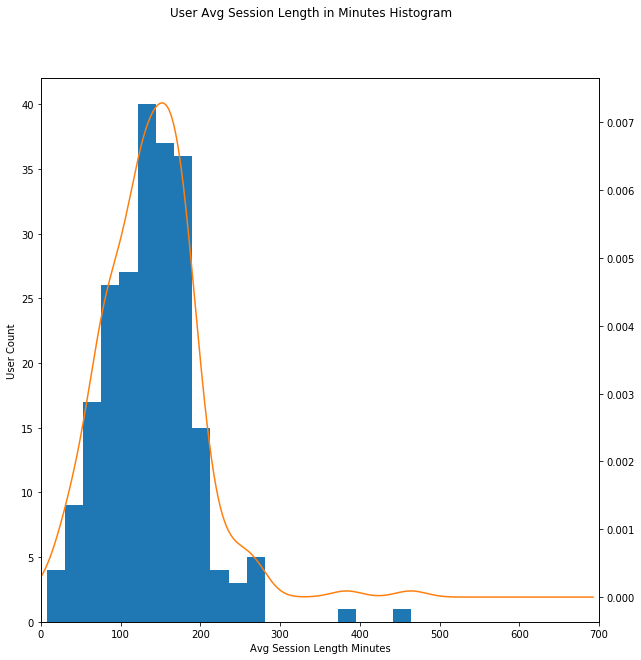

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
user_session_examine.sessionLengthMinutes.hist(bins=20, ax=ax)
user_session_examine.sessionLengthMinutes.plot(kind='kde', ax=ax, secondary_y=True)
ax.set_xlabel('Avg Session Length Minutes')
ax.set_ylabel('User Count')
ax.set_xlim([0, 700])
_=fig.suptitle('User Avg Session Length in Minutes Histogram')

In [40]:
new_sess = spark.createDataFrame(valid_sessions)

In [41]:
df = df.join(new_sess.select('newSessionId'), how='inner', on='newSessionId')

These session lengths look much more reasonable! 95% of the sessions are less than 8 hours. <br> 
Most users average around 120 minutes per session, with some listening for much longer on average. <br>
Additionally, our sessions are now unique by user. <br>
Let's do a final check of the cleaned data.

In [42]:
df.printSchema()

root
 |-- newSessionId: integer (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- activityDay: date (nullable = true)
 |-- firstActivityDay: date (nullable = true)
 |-- daysSinceFirst: integer (nullable = true)
 |-- nextHit: long (nullable = true)
 |-- nextHitDiffMin: double (nullable = true)
 |-- nextHitDiff: long (nullable = true)
 |-- sessionEnd: integer (nullable = false)
 |-- sessionPhase: long (nullable = true)

In [43]:
check_nulls(df)

{'newSessionId': 0,
 'artist': 47635,
 'auth': 0,
 'firstName': 0,
 'gender': 0,
 'lastName': 0,
 'length': 47635,
 'level': 0,
 'location': 0,
 'method': 0,
 'page': 0,
 'registration': 0,
 'song': 47635,
 'status': 0,
 'ts': 0,
 'userAgent': 0,
 'userId': 0,
 'activityDay': 0,
 'firstActivityDay': 0,
 'daysSinceFirst': 0,
 'nextHit': 0,
 'nextHitDiffMin': 0,
 'nextHitDiff': 0,
 'sessionEnd': 0,
 'sessionPhase': 0,
 'cancelFlag': 0,
 'cancelPhase': 0,
 'userCancelPhase': 0,
 'newItemInSession': 0,
 'songSkip': 0}

In [44]:
check_shape(df)

(262010, 30)


In [45]:
df.persist()

DataFrame[newSessionId: int, artist: string, auth: string, firstName: string, gender: string, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, activityDay: date, firstActivityDay: date, daysSinceFirst: int, nextHit: bigint, nextHitDiffMin: double, nextHitDiff: bigint, sessionEnd: int, sessionPhase: bigint, cancelFlag: int, cancelPhase: bigint, userCancelPhase: int, newItemInSession: int, songSkip: int]

Looks like we're ready to go!

# Exploratory Data Analysis


### Defining Churn

In our preliminary cleaning and analysis of the dataset, we revealed that the granularity of the dataset is at the event level. That is to say, every action that a user takes while using Sparkify is recorded. <br>
Two events are of particular interest to us: `Cancellation Confirmation` and `Submit Downgrade`. These events tell us whether someone has cancelled from the service or downgraded from paid to free. <br>
We previously used these events to partition user behavior into phases.

Find the cancellers.

In [46]:
cancellers = df\
    .groupby('userId', 'userCancelPhase')\
    .agg(F.max(col('cancelFlag')).alias('cancelFlag'))

In [47]:
cancellers.show()

+------+---------------+----------+
|userId|userCancelPhase|cancelFlag|
+------+---------------+----------+
|300021|            148|         0|
|    70|            194|         1|
|   134|             62|         0|
|   116|             43|         0|
|    17|             88|         1|
|100011|             13|         1|
|200007|             99|         0|
|   156|             86|         0|
|100007|              9|         1|
|    12|             47|         1|
|    77|            201|         0|
|    42|            164|         0|
|   136|             64|         0|
|200001|             93|         1|
|    95|            221|         0|
|100009|             11|         1|
|    16|             87|         0|
|   151|             81|         0|
|    45|            167|         0|
|    33|            154|         0|
+------+---------------+----------+
only showing top 20 rows



Aggregate all behavior by userId and user phase. <br>
In order to avoid data leakage we will express all of our features by unit of time. 
Aggregate features after the fact, such as NumSessions, might give an unfair advantage to our model. <br> 
You might expect cancellers to cancel after only a few sessions, thereby giving the model indirect information about the target and falsely overinflating performance on the test set.

In [48]:
user_agg = df\
    .groupby("userId", "userCancelPhase")\
    .agg(F.first(col('registration')).alias('registration'),
         F.min(col('ts')).alias("observationStart"), 
         F.max(col('ts')).alias("observationEnd"),
         F.count(col('ts')).alias('activityCount'),
         F.sum(F.when(col("page") == "NextSong", 1).otherwise(0)).alias("songsListened"),
         F.sum(F.when(col("page") == "Add to Playlist", 1).otherwise(0)).alias("songsAdded"),
         F.sum(col('songSkip')).alias('songsSkipped'),
         F.approxCountDistinct(col('artist')).alias('numUniqueArtists'),
         F.approxCountDistinct(col('song')).alias('numUniqueSongs'),
         F.sum(F.when(col("page") == "Add Friend", 1).otherwise(0)).alias("friendsAdded"),
         F.sum(F.when(col("page") == "Thumbs Up", 1).otherwise(0)).alias("thumbsUp"),
         F.sum(F.when(col("page") == "Thumbs Down", 1).otherwise(0)).alias("thumbsDown"),
         F.sum(F.when(col("page") == "Error", 1).otherwise(0)).alias("errors"),
         F.sum(F.when(col("page") == "Help", 1).otherwise(0)).alias("helpVisits"),
         F.sum(F.when(col("page") == "Submit Upgrade", 1).otherwise(0)).alias("numUpgrades"),
         F.sum(F.when(col("page") == "Submit Downgrade", 1).otherwise(0)).alias("numDowngrades"),
         F.sum(F.when(col("page") == "Roll Advert", 1).otherwise(0)).alias("advertsPlayed"),
         F.approxCountDistinct(col('newSessionId')).alias('numSessions'),
         F.first(col('level')).alias("levelAtStart"),
         F.last(col('level')).alias("levelAtEnd"),
         F.first(col('auth')).alias("authAtStart"),
         F.last(col('auth')).alias("authAtEnd"),
         F.first(col('location')).alias('location'),
         F.first(col('gender')).alias("gender"),
         F.first(col('userAgent')).alias('userAgent')
        )\
    .withColumn("observedHours", F.ceil((col('observationEnd') - col("observationStart")) / 1000 / 60 / 60))\
    .withColumn("observedDays", F.ceil(col("observedHours") / 24))\
    .withColumn("songsPerDay", col("songsListened") / col("observedDays"))\
    .withColumn("uniqueArtistsPerDay", col("numUniqueArtists") / col("observedDays"))\
    .withColumn("skippedSongRatio", col("songsSkipped") / col("songsListened"))\
    .withColumn("uniqueSongRatio", col("numUniqueSongs") / col("songsListened"))\
    .withColumn("songToActivityRatio", col("songsListened") / col("activityCount"))\
    .withColumn("songsAddedPerDay", col("songsAdded") / col("observedDays"))\
    .withColumn("friendsAddedPerDay", col("friendsAdded") / col("observedDays"))\
    .withColumn("thumbsUpPerDay", col("thumbsUp") / col("observedDays"))\
    .withColumn("thumbsDownPerDay", col("thumbsDown") / col("observedDays"))\
    .withColumn("thumbsDownRatio", col("thumbsDown") / (col("thumbsDown") + col("thumbsUp")))\
    .withColumn("errorsPerDay", col("errors") / col("observedDays"))\
    .withColumn("helpVisitsPerDay", col("helpVisits") / col("observedDays"))\
    .withColumn("advertsPerDay", col("advertsPlayed") / col("observedDays"))\
    .withColumn("sessionsPerDay", col("numSessions") / col("observedDays"))\
    .withColumn('metroArea', F.split(col('location'), ', ').getItem(0))\
    .withColumn('state', F.split(col('location'), ', ').getItem(1))\
    .join(cancellers, on=['userId', 'userCancelPhase'])\
    .select(
        'userId',
        'numUpgrades',
        'numDowngrades',
        'levelAtStart',
        'gender',
        'userAgent',
        'songsPerDay',
        'uniqueArtistsPerDay',
        'skippedSongRatio',
        'songToActivityRatio',
        'uniqueSongRatio',
        'songsAddedPerDay',
        'friendsAddedPerDay',
        'thumbsUpPerDay',
        'thumbsDownPerDay',
        'thumbsDownRatio',
        'errorsPerDay',
        'helpVisitsPerDay',
        'advertsPerDay',
        'sessionsPerDay',
        'metroArea',
        'state',
        'cancelFlag'
    )

In [49]:
user_agg.printSchema()

root
 |-- userId: string (nullable = true)
 |-- numUpgrades: long (nullable = true)
 |-- numDowngrades: long (nullable = true)
 |-- levelAtStart: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- songsPerDay: double (nullable = true)
 |-- uniqueArtistsPerDay: double (nullable = true)
 |-- skippedSongRatio: double (nullable = true)
 |-- songToActivityRatio: double (nullable = true)
 |-- uniqueSongRatio: double (nullable = true)
 |-- songsAddedPerDay: double (nullable = true)
 |-- friendsAddedPerDay: double (nullable = true)
 |-- thumbsUpPerDay: double (nullable = true)
 |-- thumbsDownPerDay: double (nullable = true)
 |-- thumbsDownRatio: double (nullable = true)
 |-- errorsPerDay: double (nullable = true)
 |-- helpVisitsPerDay: double (nullable = true)
 |-- advertsPerDay: double (nullable = true)
 |-- sessionsPerDay: double (nullable = true)
 |-- metroArea: string (nullable = true)
 |-- state: string (nullable = true)
 |-- cance

### Examine features and explore data.

In [50]:
examine = user_agg.toPandas()

Continuous Features

In [51]:
def feature_dist(df, feature, target='cancelFlag', **kwargs):
    """Plot kde of feature by target"""
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    for ttl, grp in df.groupby(target):
        grp[feature].plot(kind='kde', label=f'{target} - {ttl}', **kwargs)
    ax.set_xlabel(feature)
    ax.set_ylabel('Count/Proportion')
    ax.set_xlim([df[feature].min(), df[feature].max()])
    ax.legend()
    plt.suptitle(f'{feature} by {target}')

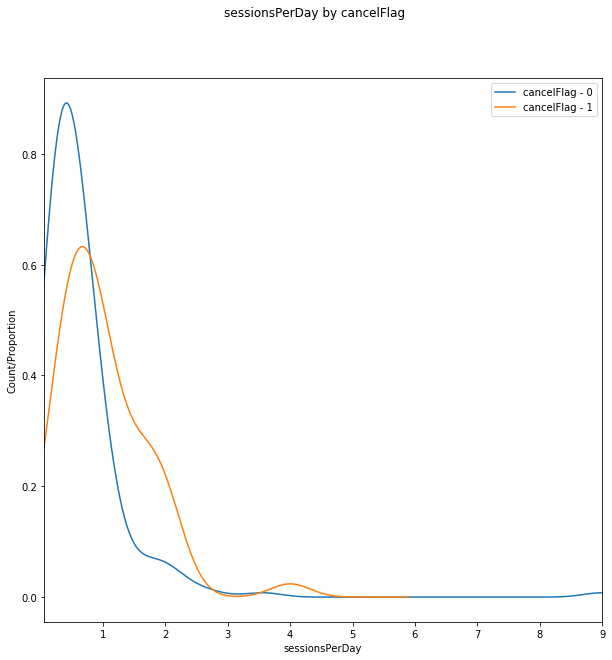

In [52]:
feature_dist(examine, 'sessionsPerDay')

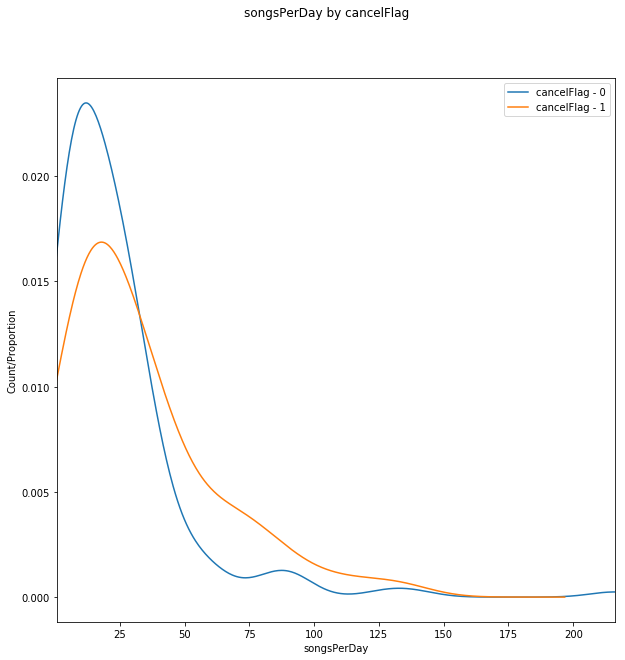

In [53]:
feature_dist(examine, 'songsPerDay')

Cancellers have slightly higher songsPerday and sessionsPerDay

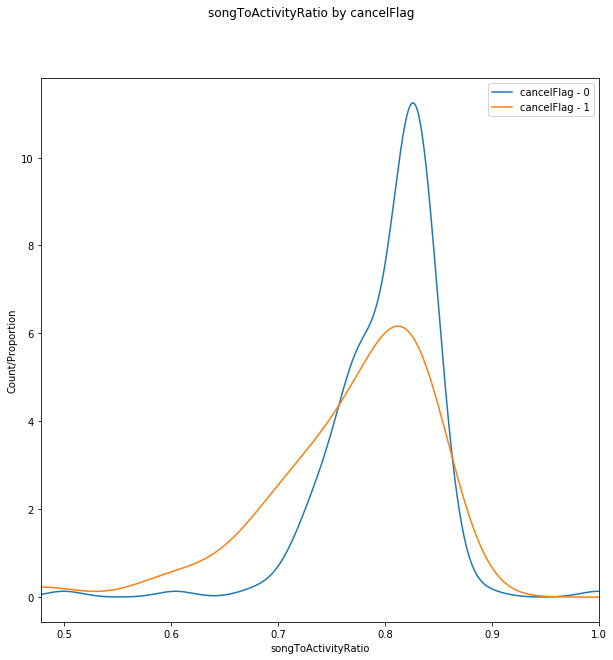

In [54]:
feature_dist(examine, 'songToActivityRatio')

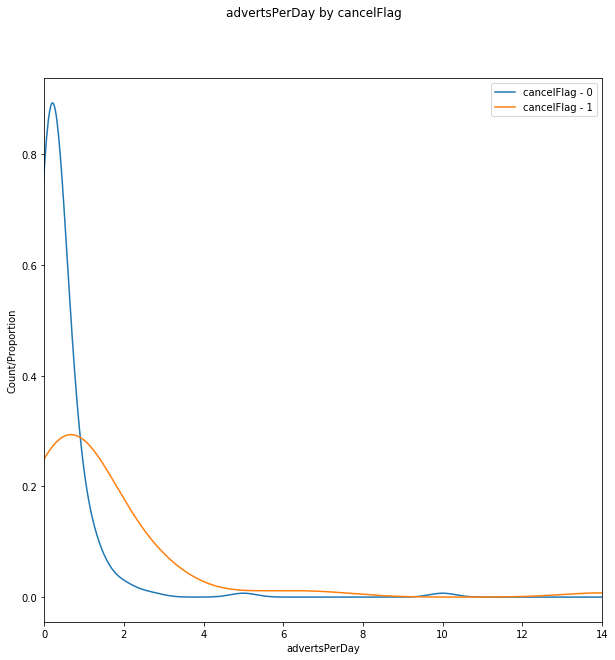

In [55]:
feature_dist(examine, 'advertsPerDay')

Cancellers have a lower songToActivityRatio (proportion of activity that is spent listening to music). <br>
Interestingly, they have a correspondingly higher advertsPerDay ratio.

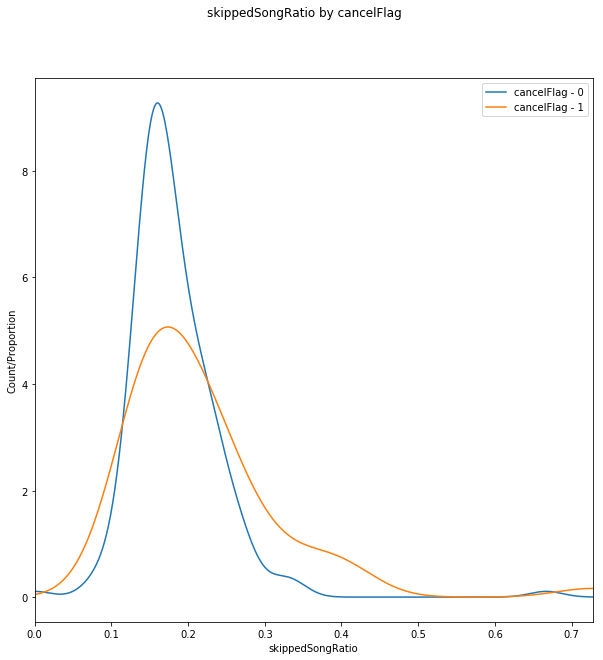

In [56]:
feature_dist(examine, 'skippedSongRatio')

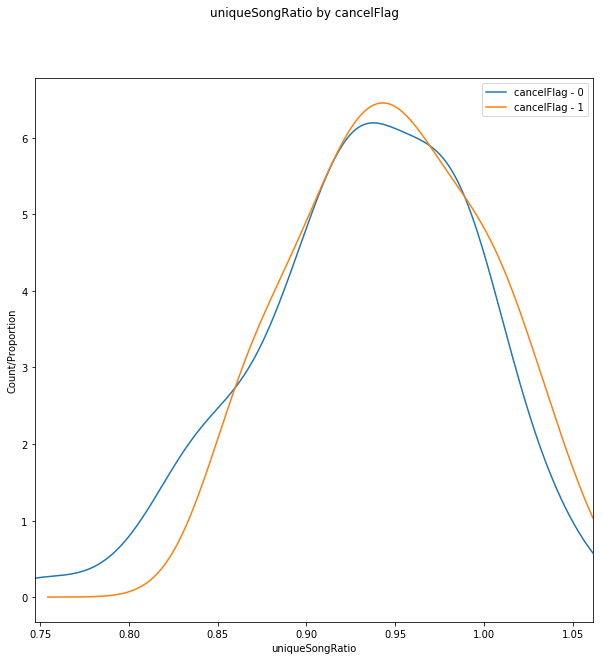

In [57]:
feature_dist(examine, 'uniqueSongRatio')

About the same on uniqueSongRatio, with perhaps a slightly higher skippedSongRatio

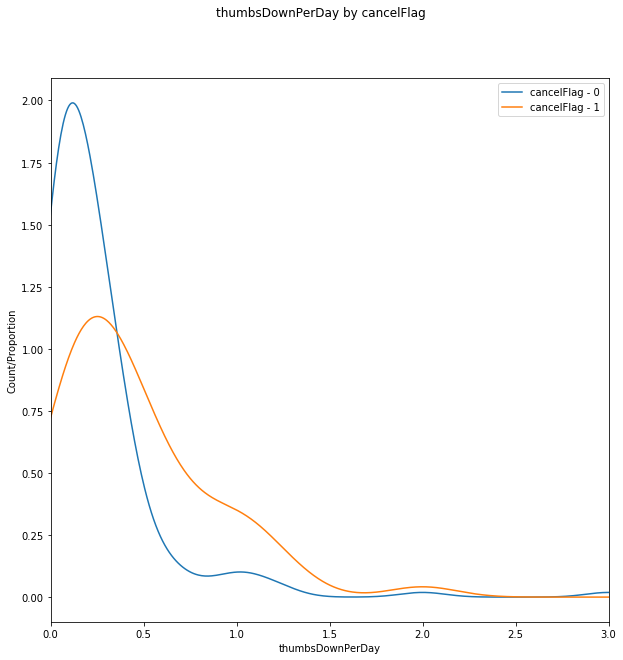

In [58]:
feature_dist(examine, 'thumbsDownPerDay')

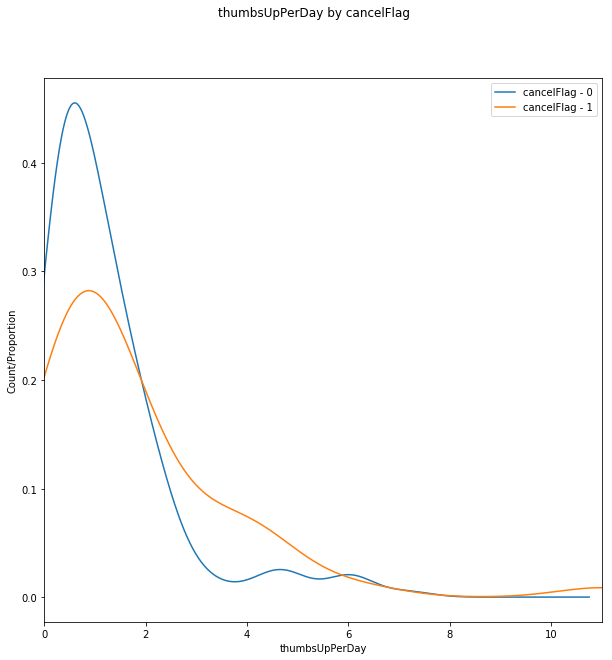

In [59]:
feature_dist(examine, 'thumbsUpPerDay')

Cancellers seem to rate songs slightly more on average

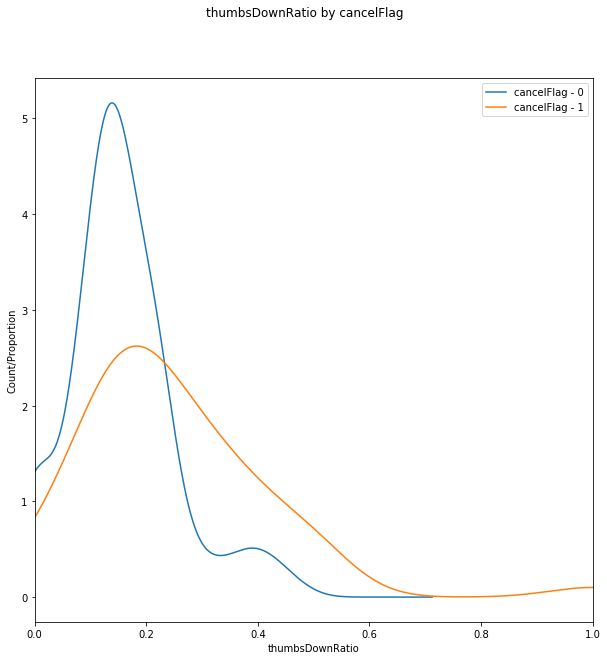

In [60]:
feature_dist(examine, 'thumbsDownRatio')

The ratio of ThumbsDown to TotalRatings is definitely higher for cancellers - displeasure with the music choices?

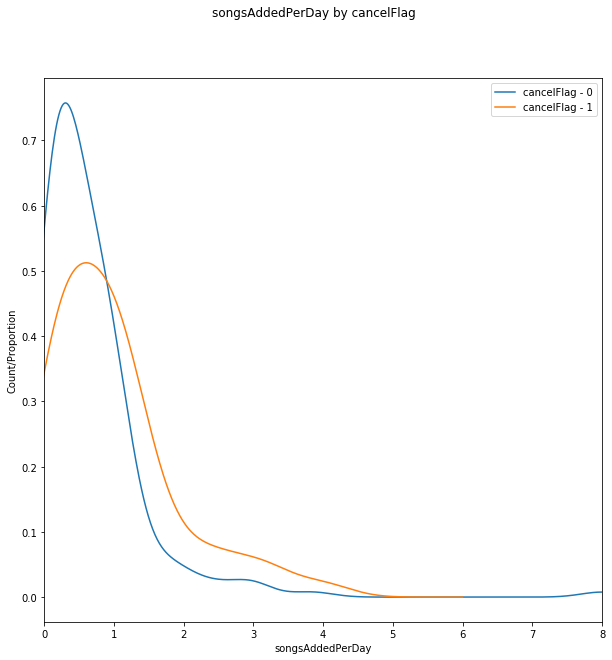

In [61]:
feature_dist(examine, 'songsAddedPerDay')

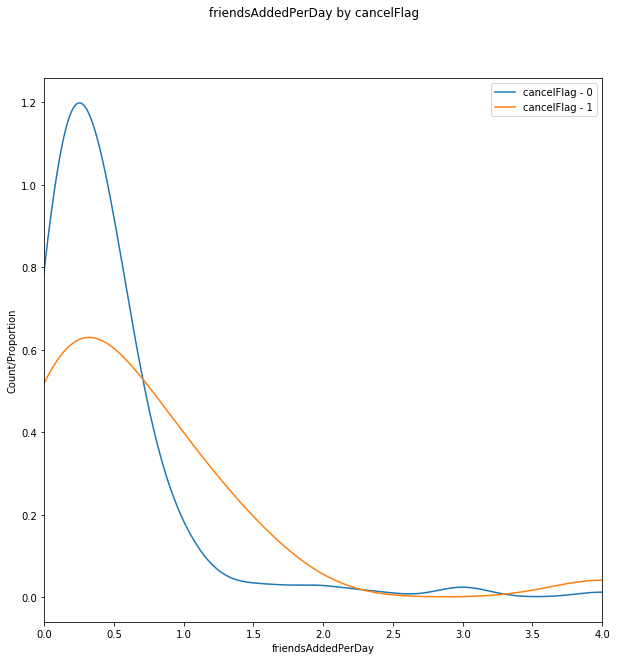

In [62]:
feature_dist(examine, 'friendsAddedPerDay')

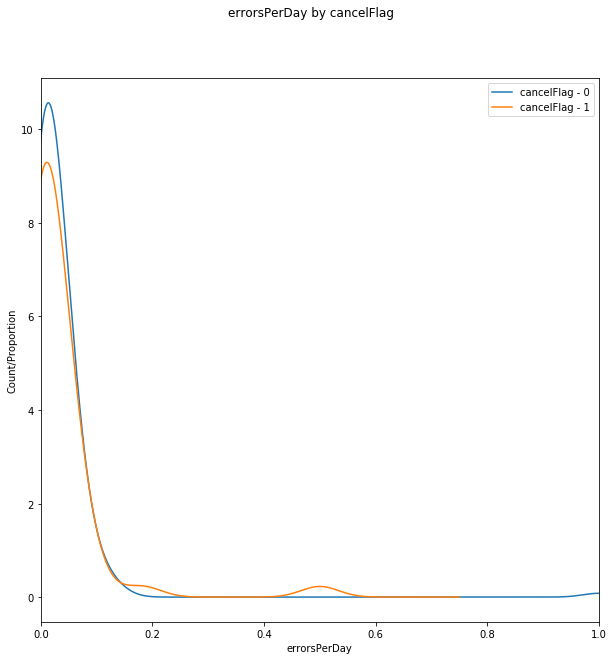

In [63]:
feature_dist(examine, 'errorsPerDay')

Slightly more friendsPerDay, no difference visible in errorsPerDay or songsAddedPerDay

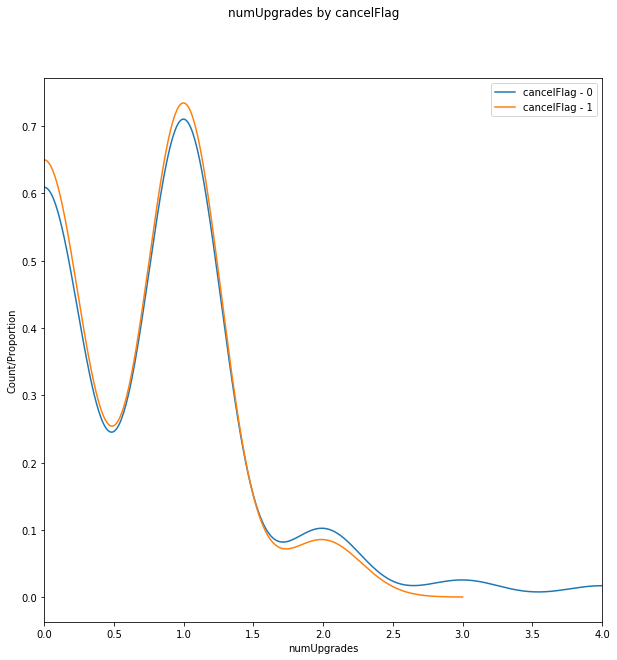

In [64]:
feature_dist(examine, 'numUpgrades')

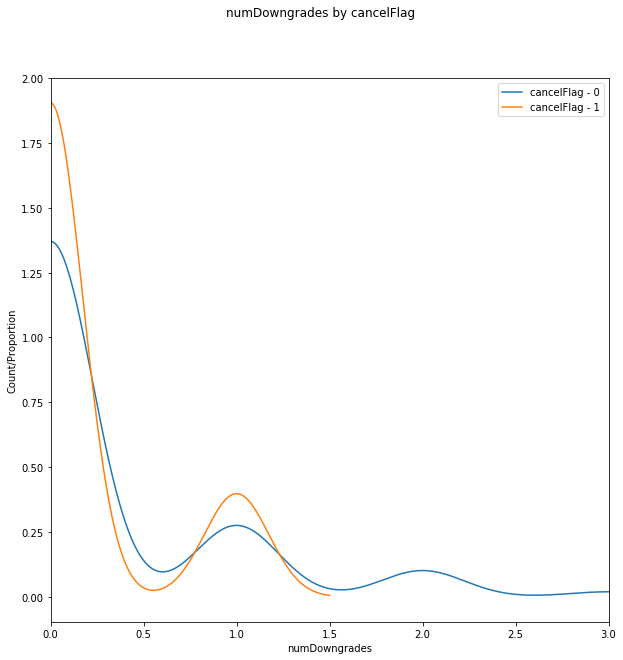

In [65]:
feature_dist(examine, 'numDowngrades')

Not much to note of the effect of users moving between levels, at least in this view.

Categorical Features

In [66]:
def feature_bar(df, feature, target='cancelFlag', **kwargs):
    """Plot counts by feature and target."""
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    data = df.groupby([feature, target]).size().unstack()
    data.plot(kind='bar', ax=ax)
    ax.set_ylabel('Count')
    plt.suptitle(f'{feature} by {target}')

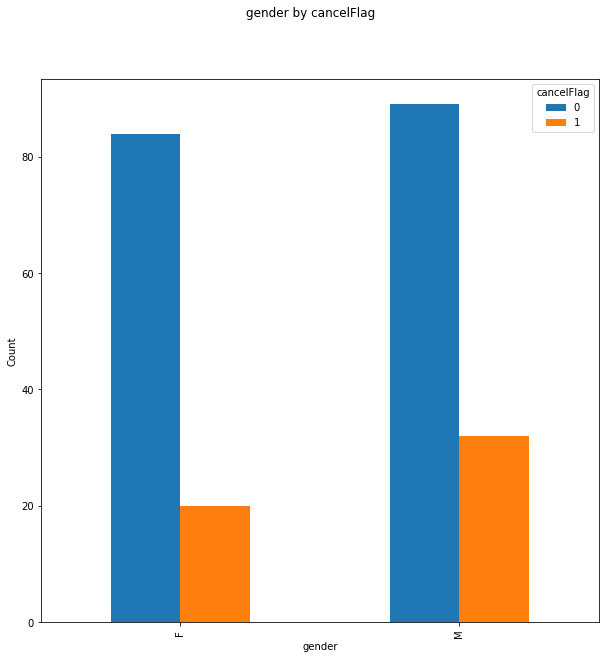

In [67]:
feature_bar(examine, 'gender')

There are more males using the platform - proportion of cancellers seems to be equal across gender.

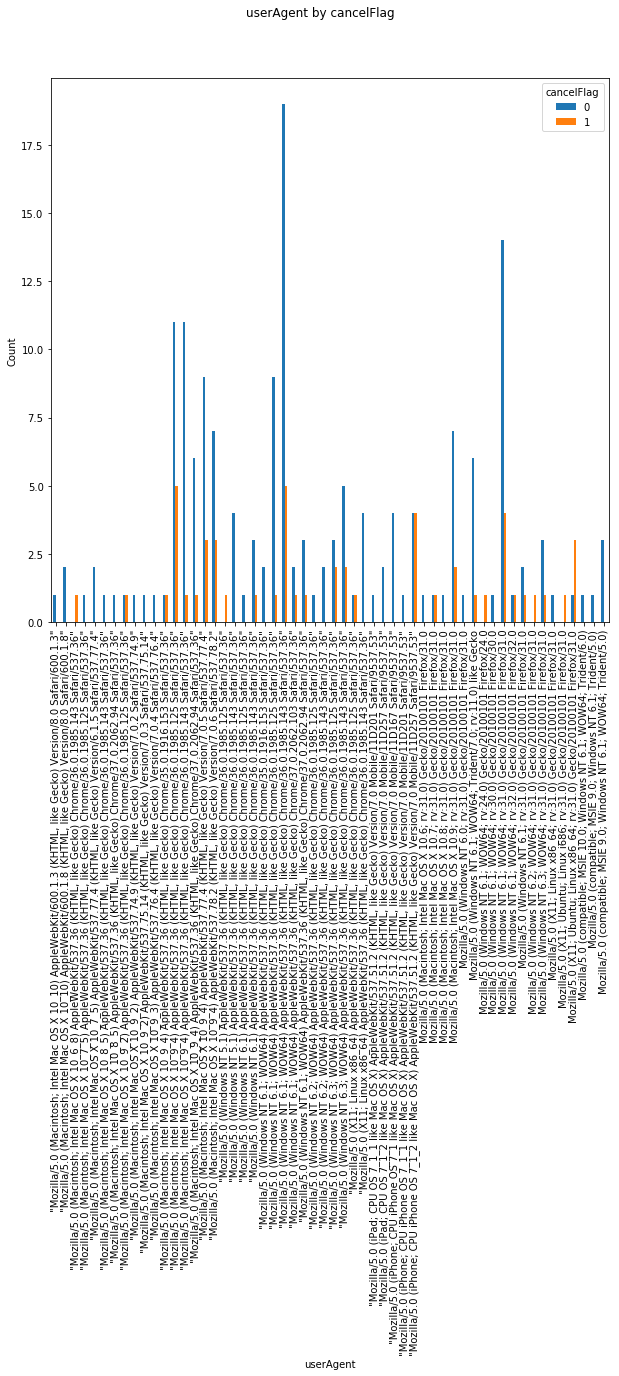

In [68]:
feature_bar(examine, 'userAgent')

There are a few distinct userAgents here - this contains information about the device. It's hard to say but it's possible there may some effect from the user's device. We can dig into this more later.

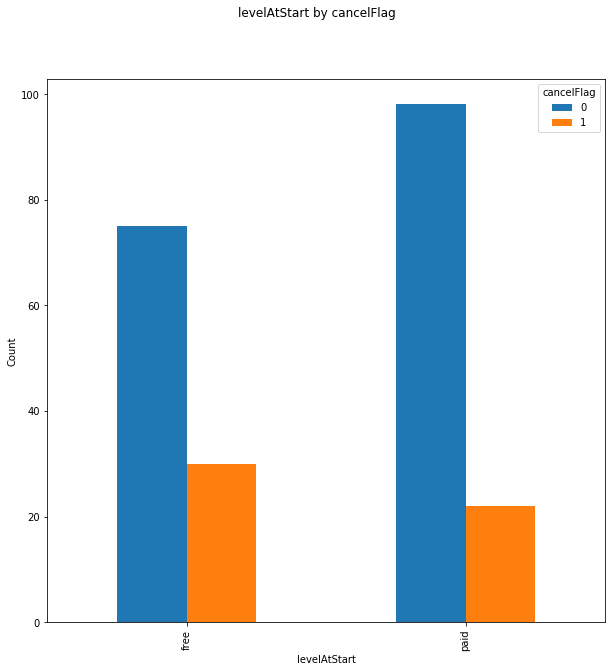

In [69]:
feature_bar(examine, 'levelAtStart')

More of Sparkify's users are on the paid level. Proportionally fewer of these are cancelling.

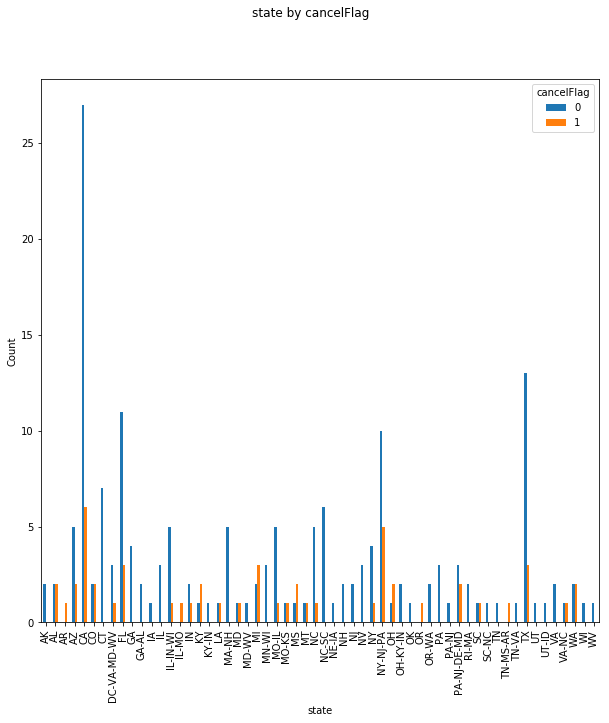

In [70]:
feature_bar(examine, 'state')

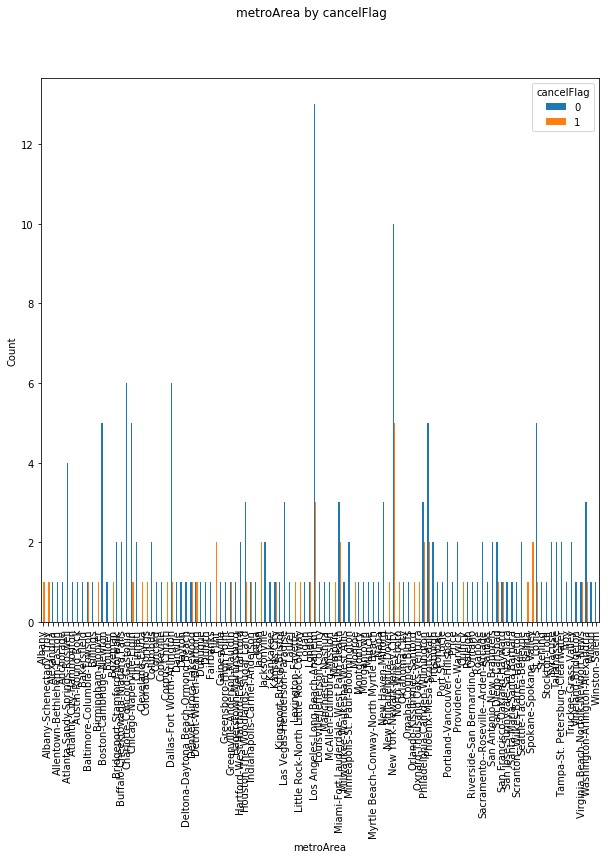

In [71]:
feature_bar(examine, 'metroArea')

There are lots of states and metroAreas in play here, with counts corresponding to population density (at a glance). Location isn't a feature that we'll explore any more.

## Feature Engineering

We've already calculated most of the numeric features that seems pertinent. <br> However, I did notice that user device type may have some effect on churn - to that end we will parse the `userAgent` field for more granular information. <br>
Additionally, the trend of user behavior over time would probably be an interesting and informative feature.<br>

#### Parse user agent

In [72]:
# source: https://medium.com/@mahadir.ahmad/how-to-parse-billion-of-user-agents-using-pyspark-f57e680727e7

# Define our function that returns parsed user agent according to UDF schema

# from user_agents
def parse_ua(ua_string):
    # parse library cannot parse None
    if ua_string is None:
        ua_string = ""

    parsed_string = parse(ua_string)

    output =  [
        parsed_string.device.model,
        parsed_string.os.family,
        parsed_string.browser.family,
        (parsed_string.is_mobile or parsed_string.is_tablet),
        ]
    # If any of the column have None value it doesn't comply with schema
    # and thus throw Null Pointer Exception
    for i in range(len(output)):
        if output[i] is None:
            output[i] = 'Unknown'
    return output


# Our schema of parsing outcome - pyspark udf
ua_parser_udf = F.udf(lambda z: parse_ua(z), StructType([
            StructField("device_model", StringType(), False),
            StructField("os_family", StringType(), False),
            StructField("browser_family", StringType(), False),
            StructField("is_mobile_or_tablet", BooleanType(), False),
        ])) 

In [73]:
# use previously defined ua_parser_udf to parse the User Agent string 
parsed_agent = user_agg\
    .select("userId", "userAgent")\
    .dropDuplicates()\
    .withColumn('parsed', ua_parser_udf('userAgent'))\
    .select( 
        "userId", 
        F.col("parsed.device_model").alias("deviceModel"),
        F.col("parsed.os_family").alias("osFamily"),
        F.col("parsed.browser_family").alias("browserFamily"),
        F.col("parsed.is_mobile_or_tablet").alias("isMobileOrTablet"),
    )

In [74]:
parsed_agent.take(1)

[Row(userId='200021', deviceModel='Mac', osFamily='Mac OS X', browserFamily='Firefox', isMobileOrTablet=False)]

In [75]:
user_agg = user_agg\
    .join(parsed_agent, on='userId')

In [76]:
user_agg.head()

Row(userId='100010', numUpgrades=0, numDowngrades=0, levelAtStart='free', gender='F', userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', songsPerDay=6.111111111111111, uniqueArtistsPerDay=5.533333333333333, skippedSongRatio=0.3381818181818182, songToActivityRatio=0.7217847769028871, uniqueSongRatio=0.9963636363636363, songsAddedPerDay=0.15555555555555556, friendsAddedPerDay=0.08888888888888889, thumbsUpPerDay=0.37777777777777777, thumbsDownPerDay=0.1111111111111111, thumbsDownRatio=0.22727272727272727, errorsPerDay=0.0, helpVisitsPerDay=0.044444444444444446, advertsPerDay=1.1555555555555554, sessionsPerDay=0.2, metroArea='Bridgeport-Stamford-Norwalk', state='CT', cancelFlag=0, deviceModel='iPhone', osFamily='iOS', browserFamily='Mobile Safari', isMobileOrTablet=True)

#### Add user behavior trend/slope

Aggregate user behavior to day level. `daysSinceFirst` is the nth day of activity since the first observation of the user.

In [77]:
user_behavior = df\
    .groupby('userId', 'daysSinceFirst')\
    .agg(F.count('*').alias('numInteractions'))\
    .orderBy('userId', 'daysSinceFirst')

In [78]:
user_behavior.orderBy(desc('userId')).show()

+------+--------------+---------------+
|userId|daysSinceFirst|numInteractions|
+------+--------------+---------------+
|    99|             0|             41|
|    99|            52|            141|
|    99|            50|             88|
|    99|            47|             23|
|    99|            46|              1|
|    99|             5|             26|
|    99|            55|            126|
|    99|             7|             16|
|    99|            35|              8|
|    99|            44|             54|
|    99|            32|             65|
|    99|            34|             12|
|    99|            54|              7|
|    99|             1|              6|
|    98|            40|            370|
|    98|            20|              8|
|    98|            24|            194|
|    98|            12|              4|
|    98|             8|             25|
|    98|            51|            266|
+------+--------------+---------------+
only showing top 20 rows



In [79]:
example = user_behavior.filter("userId == '17'").toPandas()

In [80]:
cancellers.filter('cancelFlag = 1').show()

+------+---------------+----------+
|userId|userCancelPhase|cancelFlag|
+------+---------------+----------+
|    70|            194|         1|
|    17|             88|         1|
|100011|             13|         1|
|100007|              9|         1|
|    12|             47|         1|
|200001|             93|         1|
|100009|             11|         1|
|    32|            153|         1|
|100022|             23|         1|
|   103|             29|         1|
|200017|            108|         1|
|     3|            126|         1|
|100024|             25|         1|
|100021|             22|         1|
|    28|            124|         1|
|    73|            197|         1|
|   121|             49|         1|
|300007|            134|         1|
|200015|            106|         1|
|   143|             72|         1|
+------+---------------+----------+
only showing top 20 rows



In [81]:
day_idx = example.daysSinceFirst
num = example.numInteractions
    
continuous_y = np.zeros(day_idx.max() + 1)
continuous_x = np.arange(0, day_idx.max() + 1)
continuous_y[day_idx] = num
    
# cannot fit a line to a single point
if len(continuous_y) == 1:
    slope, intercept = 0.001, 0.001
else:
    slope, intercept = np.polyfit(continuous_x[-21:], continuous_y[-21:], deg=1)

In [82]:
slope, intercept

(29.236363636363635, -45.999999999999986)

Text(0.5,0.98,'Interactions Trends for userId 17')

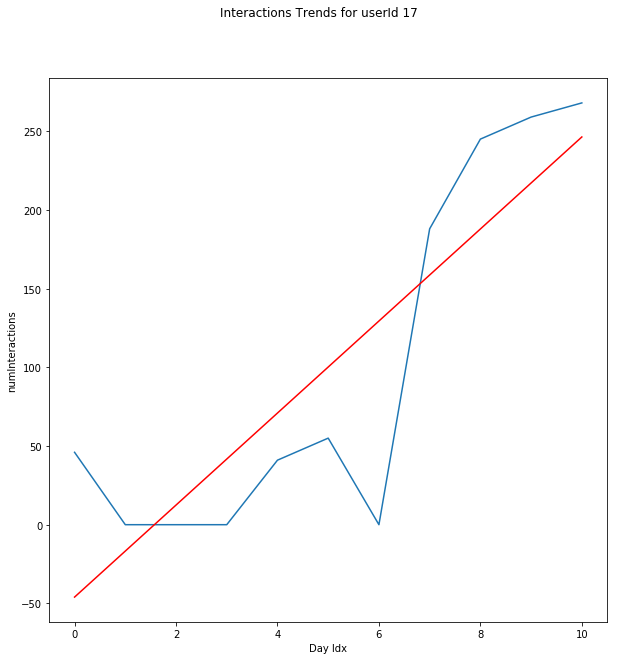

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(continuous_x, continuous_y)
trend_y = slope * continuous_x[-21:] + intercept
ax.plot(continuous_x[-21:], trend_y[-21:], c='red')
ax.set_xlabel('Day Idx')
ax.set_ylabel('numInteractions')
fig.suptitle('Interactions Trends for userId 17')

Define a pandas vectorized GROUPED_MAP UDF based on the above to fit a trendline to user behavior from start to finish. <br>
Fill in missing days of user behavior with 0's. <br>
https://docs.databricks.com/spark/latest/spark-sql/udf-python-pandas.html

In [84]:
import pyarrow

# output of the UDF
trend_schema = StructType([
    StructField("userId", StringType(), False),
    StructField("slope", DoubleType(), False),
    StructField("intercept", DoubleType(), False)
])

# define the UDF - expects a dataframe as output, with the schema of the new df following the defined schema
@pandas_udf(trend_schema, PandasUDFType.GROUPED_MAP)
def fit_trend(pdf):
    userId = pdf.userId[0]
    day_idx = pdf.daysSinceFirst
    num = pdf.numInteractions
    
    continuous_y = np.zeros(day_idx.max() + 1)
    continuous_x = np.arange(0, day_idx.max() + 1)
    continuous_y[day_idx] = num
    
    # dont' fit a line if they don't have enough data
    if len(continuous_y) <= 7 :
        slope, intercept = 0.001, 0.001
    else:
        slope, intercept = np.polyfit(continuous_x[-7:], continuous_y[-7:], deg=1)
    
    df = pd.DataFrame([[userId, slope, intercept]], columns=["userId", "slope", "intercept"])

    return df

In [85]:
user_trend = user_behavior\
    .groupby('userId')\
    .apply(fit_trend)

In [86]:
user_trend.show()

+------+-------------------+-------------------+
|userId|              slope|          intercept|
+------+-------------------+-------------------+
|100010|  3.535714285714289| -140.2500000000002|
|200002|               15.0|             -610.0|
|   125|              0.001|              0.001|
|   124|  11.28571428571426| -606.9999999999985|
|    51| -25.42857142857139| 472.57142857142816|
|     7| 0.4285714285714323|-16.571428571428747|
|    15| 26.571428571428633|-1322.1428571428603|
|    54|-15.749999999999972|  710.9642857142843|
|   155|  4.607142857142855| -97.67857142857135|
|100014|  7.928571428571401|-290.71428571428453|
|   132| 12.999999999999924|  -544.571428571425|
|   154|  3.214285714285704| -66.42857142857115|
|   101|-35.178571428571466|  556.4285714285717|
|    11| 3.8571428571428505|-187.71428571428532|
|   138| 12.071428571428559| -586.9999999999993|
|300017| 12.714285714285744| -658.5714285714301|
|100021|               19.5| -793.0000000000001|
|    29|  8.67857142

In [87]:
user_agg = user_agg\
    .join(user_trend, on='userId')

In [88]:
user_agg.persist()
user_agg.take(2)

[Row(userId='100010', numUpgrades=0, numDowngrades=0, levelAtStart='free', gender='F', userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', songsPerDay=6.111111111111111, uniqueArtistsPerDay=5.533333333333333, skippedSongRatio=0.3381818181818182, songToActivityRatio=0.7217847769028871, uniqueSongRatio=0.9963636363636363, songsAddedPerDay=0.15555555555555556, friendsAddedPerDay=0.08888888888888889, thumbsUpPerDay=0.37777777777777777, thumbsDownPerDay=0.1111111111111111, thumbsDownRatio=0.22727272727272727, errorsPerDay=0.0, helpVisitsPerDay=0.044444444444444446, advertsPerDay=1.1555555555555554, sessionsPerDay=0.2, metroArea='Bridgeport-Stamford-Norwalk', state='CT', cancelFlag=0, deviceModel='iPhone', osFamily='iOS', browserFamily='Mobile Safari', isMobileOrTablet=True, slope=3.535714285714289, intercept=-140.2500000000002),
 Row(userId='200002', numUpgrades=1, numDowngrades=0, levelAtSt

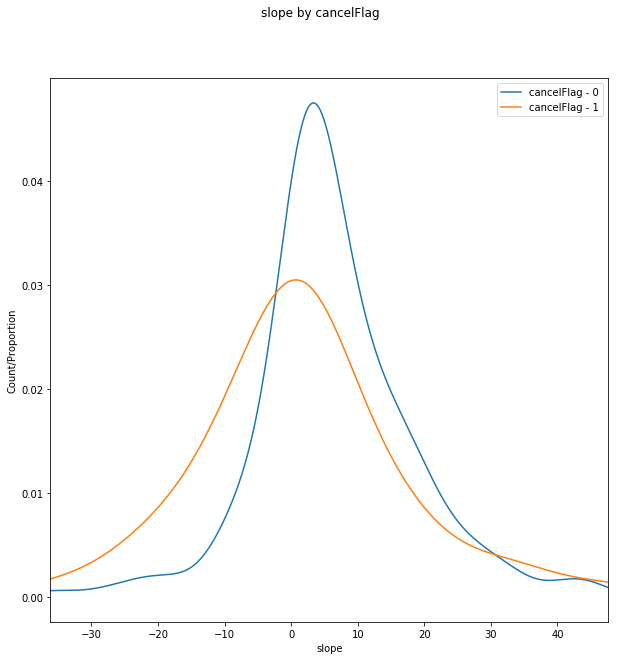

In [89]:
ut = user_agg.toPandas()
feature_dist(ut, 'slope')

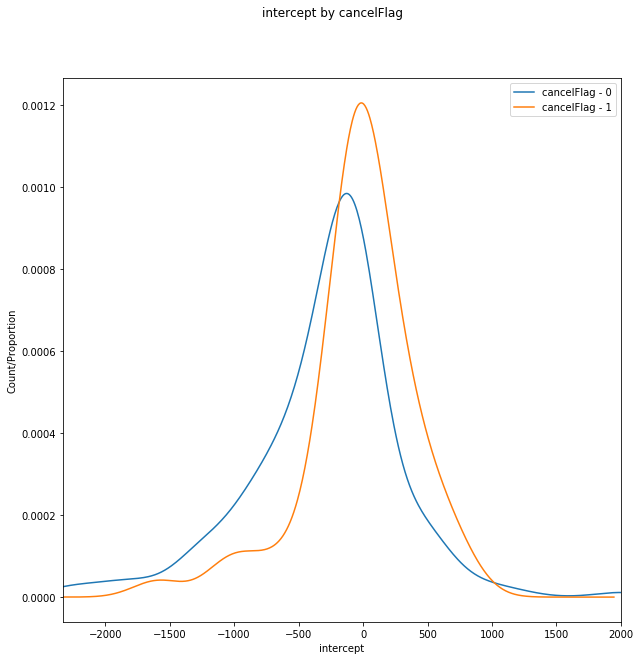

In [90]:
feature_dist(ut, 'intercept')

Check dtypes and nulls

In [91]:
nulls = check_nulls(user_agg)

In [92]:
null_cols = [k for k,v in nulls.items() if v > 0]
null_cols

['thumbsDownRatio']

In [93]:
user_agg.printSchema()

root
 |-- userId: string (nullable = true)
 |-- numUpgrades: long (nullable = true)
 |-- numDowngrades: long (nullable = true)
 |-- levelAtStart: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- songsPerDay: double (nullable = true)
 |-- uniqueArtistsPerDay: double (nullable = true)
 |-- skippedSongRatio: double (nullable = true)
 |-- songToActivityRatio: double (nullable = true)
 |-- uniqueSongRatio: double (nullable = true)
 |-- songsAddedPerDay: double (nullable = true)
 |-- friendsAddedPerDay: double (nullable = true)
 |-- thumbsUpPerDay: double (nullable = true)
 |-- thumbsDownPerDay: double (nullable = true)
 |-- thumbsDownRatio: double (nullable = true)
 |-- errorsPerDay: double (nullable = true)
 |-- helpVisitsPerDay: double (nullable = true)
 |-- advertsPerDay: double (nullable = true)
 |-- sessionsPerDay: double (nullable = true)
 |-- metroArea: string (nullable = true)
 |-- state: string (nullable = true)
 |-- cance

In [94]:
# to impute, column datatype must be Double
for c in null_cols:
    user_agg = user_agg.withColumn(c, col(c).cast('double'))
    
# we will treat bool values as categorical and encode them - thus, cast them to string
for c, d in user_agg.dtypes:
    if d == 'boolean':
        user_agg = user_agg.withColumn(c, col(c).cast('string'))

In [95]:
user_agg.printSchema()

root
 |-- userId: string (nullable = true)
 |-- numUpgrades: long (nullable = true)
 |-- numDowngrades: long (nullable = true)
 |-- levelAtStart: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- songsPerDay: double (nullable = true)
 |-- uniqueArtistsPerDay: double (nullable = true)
 |-- skippedSongRatio: double (nullable = true)
 |-- songToActivityRatio: double (nullable = true)
 |-- uniqueSongRatio: double (nullable = true)
 |-- songsAddedPerDay: double (nullable = true)
 |-- friendsAddedPerDay: double (nullable = true)
 |-- thumbsUpPerDay: double (nullable = true)
 |-- thumbsDownPerDay: double (nullable = true)
 |-- thumbsDownRatio: double (nullable = true)
 |-- errorsPerDay: double (nullable = true)
 |-- helpVisitsPerDay: double (nullable = true)
 |-- advertsPerDay: double (nullable = true)
 |-- sessionsPerDay: double (nullable = true)
 |-- metroArea: string (nullable = true)
 |-- state: string (nullable = true)
 |-- cance

In [96]:
final_dataset = user_agg.drop('userAgent', 'metroArea', 'state')
final_dataset.persist()
final_dataset.take(1)

[Row(userId='100010', numUpgrades=0, numDowngrades=0, levelAtStart='free', gender='F', songsPerDay=6.111111111111111, uniqueArtistsPerDay=5.533333333333333, skippedSongRatio=0.3381818181818182, songToActivityRatio=0.7217847769028871, uniqueSongRatio=0.9963636363636363, songsAddedPerDay=0.15555555555555556, friendsAddedPerDay=0.08888888888888889, thumbsUpPerDay=0.37777777777777777, thumbsDownPerDay=0.1111111111111111, thumbsDownRatio=0.22727272727272727, errorsPerDay=0.0, helpVisitsPerDay=0.044444444444444446, advertsPerDay=1.1555555555555554, sessionsPerDay=0.2, cancelFlag=0, deviceModel='iPhone', osFamily='iOS', browserFamily='Mobile Safari', isMobileOrTablet='true', slope=3.535714285714289, intercept=-140.2500000000002)]

# Modeling

Here we'll be:
 - Splitting into train and test
 - Transforming features in a pipeline
     - One Hot Encoding categorical columns
     - Fill in NaN values for numeric columns with median imputation
     - Scaling all numeric columns
 - Fitting a few models and tuning hyper parameters
 - Evaluating our models

Split data before performing feature cleaning to avoid data leakage.

In [97]:
SEED = 42
(trainingData, testData) = final_dataset.randomSplit([0.75, 0.25], seed=SEED)

### Pipeline stages

#### String Index and One Hot Encode categorical columns

In this stage we will be transforming our categorical columns into something usable by machine learning algorithms. Some machine learning algorithms in scikit-learn, such as RandomForestClassifier, happily take categorical features as-is. 
However, in PySpark we must use a VectorAssembler to prep our features for model training. The Assembler will complain if we try to feed it string values.

Briefly, here is the idea behind what we're about to do. <br>
If there are `n` unique categories in our column, StringIndexing returns numbers ranging from 0 to `n - 1` for each string, ordered by decreasing occurrence of the string value. 
This alone would be enough to allow our categorical features to play with VectorAssembler; after all, we've transformed strings into numbers. There is a trap here though in the fact that our model will see this feature as having inherent ordering. If our categories are in fact not ordered then this will be a problem.

We solve this by One Hot Encoding our transformed categorical columns.
In short, OHE creates a new binary flag column for each unique value in the categorical column.
<br> Beware! For fields with high cardinality (many unique values), this will force creation of many new columns.

For our dataset this shouldn't pose an issue. Most of our categorical features are low cardinality and we already grouped the `state` and `metroArea` fields in preparation for our transformations.


At this point we are defining the stages of our Pipeline - the actual transformation will take place later.

In [98]:
encode_cols = [c for c,d in final_dataset.dtypes if d == "string" and c != "userId"]
encode_cols

['levelAtStart',
 'gender',
 'deviceModel',
 'osFamily',
 'browserFamily',
 'isMobileOrTablet']

In [99]:
encode_stages = []
for name in encode_cols:
    strIndexer = StringIndexer(inputCol=name, outputCol=f"{name}_Idx")
    oneHotEncoder = OneHotEncoderEstimator(
        inputCols=[f"{name}_Idx"],
        outputCols=[f"{name}_vec"]
    )
    encode_stages += [strIndexer, oneHotEncoder]

#### Impute median for all numeric columns with missing values
Using our previously defined list of columns with empty values, we'll create the imputation stage of our pipeline.

In [100]:
imputer = Imputer(inputCols=null_cols, outputCols = [f"{c}_Impute" for c in null_cols], strategy="median")

#### Final transformed features list

In [101]:
exclude_cols = encode_cols + null_cols + ['userId', 'cancelFlag']
feats = [c for c in final_dataset.columns if c not in exclude_cols] + \
    [f'{c}_vec' for c in encode_cols] +\
    [f'{c}_Impute' for c in null_cols]

feats

['numUpgrades',
 'numDowngrades',
 'songsPerDay',
 'uniqueArtistsPerDay',
 'skippedSongRatio',
 'songToActivityRatio',
 'uniqueSongRatio',
 'songsAddedPerDay',
 'friendsAddedPerDay',
 'thumbsUpPerDay',
 'thumbsDownPerDay',
 'errorsPerDay',
 'helpVisitsPerDay',
 'advertsPerDay',
 'sessionsPerDay',
 'slope',
 'intercept',
 'levelAtStart_vec',
 'gender_vec',
 'deviceModel_vec',
 'osFamily_vec',
 'browserFamily_vec',
 'isMobileOrTablet_vec',
 'thumbsDownRatio_Impute']

In [102]:
# assemble all features into a single vector column
vec_assembler = VectorAssembler(inputCols=feats, outputCol="features")

In [103]:
all_stages = encode_stages + [imputer, vec_assembler]

In [104]:
all_stages

[StringIndexer_790ff54ad063,
 OneHotEncoderEstimator_77b1beaafb1f,
 StringIndexer_35feba4c5e6e,
 OneHotEncoderEstimator_b6b88f6b4719,
 StringIndexer_5c64b85b8f54,
 OneHotEncoderEstimator_b670adb48e90,
 StringIndexer_de020a21d94d,
 OneHotEncoderEstimator_86c54d8d6174,
 StringIndexer_e7efe4631cea,
 OneHotEncoderEstimator_cc01bab759e9,
 StringIndexer_9990a0409bcf,
 OneHotEncoderEstimator_c5a5ed42b4d7,
 Imputer_4bf230bd6f64,
 VectorAssembler_6ef975f1984a]

#### Fit the pipeline to the training data

In [105]:
pipe_model = Pipeline(stages=all_stages).fit(trainingData)

In [106]:
trainingTransformed = pipe_model.transform(trainingData)
testTransformed = pipe_model.transform(testData)

We've now wrapped all of our preprocessing steps up into stages in a Pipeline. Neat!

In [107]:
trainingTransformed.persist()
trainingTransformed.take(1)
testTransformed.persist()
testTransformed.take(1)

[Row(userId='200002', numUpgrades=1, numDowngrades=0, levelAtStart='paid', gender='M', songsPerDay=8.41304347826087, uniqueArtistsPerDay=7.173913043478261, skippedSongRatio=0.15503875968992248, songToActivityRatio=0.8164556962025317, uniqueSongRatio=0.9741602067183462, songsAddedPerDay=0.17391304347826086, friendsAddedPerDay=0.08695652173913043, thumbsUpPerDay=0.45652173913043476, thumbsDownPerDay=0.13043478260869565, thumbsDownRatio=0.2222222222222222, errorsPerDay=0.0, helpVisitsPerDay=0.043478260869565216, advertsPerDay=0.15217391304347827, sessionsPerDay=0.21739130434782608, cancelFlag=0, deviceModel='iPhone', osFamily='iOS', browserFamily='Mobile Safari', isMobileOrTablet='true', slope=15.0, intercept=-610.0, levelAtStart_Idx=0.0, levelAtStart_vec=SparseVector(1, {0: 1.0}), gender_Idx=0.0, gender_vec=SparseVector(1, {0: 1.0}), deviceModel_Idx=2.0, deviceModel_vec=SparseVector(3, {2: 1.0}), osFamily_Idx=2.0, osFamily_vec=SparseVector(4, {2: 1.0}), browserFamily_Idx=3.0, browserFami

In [108]:
rf = RandomForestClassifier(labelCol="cancelFlag",
                            featuresCol="features", 
                            maxDepth=10, 
                            numTrees=100, 
                            seed=SEED)

In [109]:
model = rf.fit(trainingTransformed)

In [110]:
transformed = model.transform(trainingTransformed)

In [111]:
evaluator = BinaryClassificationEvaluator(
    labelCol="cancelFlag", 
    rawPredictionCol="rawPrediction"
)

print(f"AUC on Train Set {evaluator.evaluate(transformed)}")

AUC on Train Set 1.0


By default the BinaryClassificationEvaluator returns AUC, area under the ROC curve. AUC is 1.0 on the training set, which is a perfect fit - suspicious.

In [112]:
test_transformed = model.transform(testTransformed)

In [113]:
print(f"AUC on Test Set {evaluator.evaluate(test_transformed)}")

AUC on Test Set 0.6944444444444445


However, AUC on the test set is only 0.70. This indicates that our forest is overfitting.

RandomForest gives us the ability to see feature importance as well, which is quite nice.

In [114]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    """Extract feature importance from RandomForest
        Args: 
            featureImp (model.featureImportances): feature importances from PySpark model
            dataset (PySpark dataframe)
            featuresCol (string): name of featuresCol
        Returns 
            varslist (pandas dataframe): sorted dataframe of variable name and importance
            
    """
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))


In [115]:
feats = ExtractFeatureImp(model.featureImportances, transformed, "features")
feats['cum_score'] = feats.score.cumsum()
feats.head(25)

,idx,name,score,cum_score
13,13,advertsPerDay,0.092979,0.092979
17,31,thumbsDownRatio_Impute,0.080278,0.173258
6,6,uniqueSongRatio,0.074135,0.247393
10,10,thumbsDownPerDay,0.070681,0.318074
14,14,sessionsPerDay,0.062307,0.380381
16,16,intercept,0.059709,0.440090
3,3,uniqueArtistsPerDay,0.059635,0.499725
7,7,songsAddedPerDay,0.057309,0.557034
8,8,friendsAddedPerDay,0.051305,0.608339
15,15,slope,0.045651,0.653990


Let's try a GBT Classifier too

In [116]:
gbt = GBTClassifier(labelCol="cancelFlag", 
                    featuresCol="features", 
                    maxDepth=4,
                    maxIter=30,
                    seed=SEED)

In [117]:
gbt_model = gbt.fit(trainingTransformed)

In [118]:
gbt_transformed = gbt_model.transform(trainingTransformed)
print(f"AUC on Train Set {evaluator.evaluate(gbt_transformed)}")

AUC on Train Set 1.0


In [119]:
gbt_test = gbt_model.transform(testTransformed)
print(f"AUC on Test Set {evaluator.evaluate(gbt_test)}")

AUC on Test Set 0.8099415204678363


In [120]:
feats = ExtractFeatureImp(gbt_model.featureImportances, gbt_transformed, "features")
feats['cum_score'] = feats.score.cumsum()
feats.head(25)

,idx,name,score,cum_score
6,6,uniqueSongRatio,0.122059,0.122059
13,13,advertsPerDay,0.111318,0.233378
10,10,thumbsDownPerDay,0.091978,0.325356
8,8,friendsAddedPerDay,0.077575,0.402931
3,3,uniqueArtistsPerDay,0.073152,0.476083
17,31,thumbsDownRatio_Impute,0.070947,0.547030
14,14,sessionsPerDay,0.065957,0.612987
12,12,helpVisitsPerDay,0.060530,0.673517
5,5,songToActivityRatio,0.054306,0.727823
7,7,songsAddedPerDay,0.053011,0.780834


And a logistic regression.

In [121]:
lr = LogisticRegression(labelCol="cancelFlag", 
                        featuresCol="features", 
                        regParam=0.5, 
                        maxIter=10)

In [122]:
lr_model = lr.fit(trainingTransformed)
lr_transformed = lr_model.transform(trainingTransformed)
print(f"AUC on Train Set {evaluator.evaluate(lr_transformed)}")

AUC on Train Set 0.8442721791559014


In [125]:
lr_test = lr_model.transform(testTransformed)
print(f"AUC on Test Set {evaluator.evaluate(lr_test)}")

AUC on Test Set 0.6140350877192984


GBT is our most promising so far. <br>
We'll use Cross Validation and Grid Search to see if we can make our our GBT better. <br>
Using PySpark's `CrossValidator`, we can perform an exhaustive search over the supplied hyperparameters. We'll only use 4 folds for Cross Validation - normally we would use 5+ but Grid Search is very computationally expensive. <br>
Additionally, we'll switch our evaluator over to one using area under the Precision-Recall curve, which is better suited for imbalanced classes.

In [123]:
aupr_evaluator = BinaryClassificationEvaluator(
    labelCol="cancelFlag", 
    rawPredictionCol="rawPrediction",
    metricName="areaUnderPR"
)

paramGrid = ParamGridBuilder()\
    .addGrid(gbt.maxDepth, [4, 6, 8])\
    .addGrid(gbt.maxIter, [20])\
    .build()

cv = CrossValidator(
    estimator=gbt, 
    evaluator=aupr_evaluator, 
    estimatorParamMaps=paramGrid,
    numFolds=3,
)

cvModel = cv.fit(trainingTransformed)

In [124]:
list(zip(cvModel.avgMetrics, paramGrid))

[(0.5273381021784819,
  {Param(parent='GBTClassifier_fdf5d2fda90a', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 4,
   Param(parent='GBTClassifier_fdf5d2fda90a', name='maxIter', doc='max number of iterations (>= 0).'): 20}),
 (0.41153353180694086,
  {Param(parent='GBTClassifier_fdf5d2fda90a', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 6,
   Param(parent='GBTClassifier_fdf5d2fda90a', name='maxIter', doc='max number of iterations (>= 0).'): 20}),
 (0.39760589827820514,
  {Param(parent='GBTClassifier_fdf5d2fda90a', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 8,
   Param(parent='GBTClassifier_fdf5d2fda90a', name='maxIter', doc='max number of iterations (>= 0).'): 20})]

In [125]:
perf = pd.DataFrame(paramGrid, index=cvModel.avgMetrics).reset_index()
perf.columns=['AvgAUCPR', 'maxDepth', 'numTrees']
perf

,AvgAUCPR,maxDepth,numTrees
0,0.527338,4,20
1,0.411534,6,20
2,0.397606,8,20


Retrain model with best hyper params

In [124]:
new_gbt = ""

new_gbt_model = new_gbt.fit(trainingTransformed)

In [151]:
transformed = new_gbt_model.transform(trainingTransformed)

In [152]:
test_transformed = new_gbt_model.transform(testTransformed)

In [155]:
print(f"AUC-PR on Train Set {aupr_evaluator.evaluate(transformed)}")

AUC-PR on Train Set 1.0


In [156]:
print(f"AUC-PR on Test Set {aupr_evaluator.evaluate(test_transformed)}")

AUC-PR on Test Set 0.3828254015035624
